# Generalized linear discriminants

In the last post we saw that the least-squares-method could fit simple datasets, but struggled as soon as, for example, outliers came into play.

$$
    w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 + w_3 \cdot x_1^2 + w_4 \cdot x_2^2 + w_5 \cdot x_1 \cdot x_2 \\
    = \\
    v_0 + v_1 \cdot x_1 + v_2 \cdot x_2 + v_3 \cdot x_1^2 + v_4 \cdot x_2^2 + v_5 \cdot x_1 \cdot x_2 \\
    \iff \\
    w_0 + w_1 \cdot x_1 + w_3 \cdot x_1^2 - v_0 + v_1 \cdot x_1 - v_3 \cdot x_1^2 = v_2 \cdot x_2 + v_4 \cdot x_2^2 + v_5 \cdot x_1 \cdot x_2 - w_2 \cdot x_2 - w_4 \cdot x_2^2 - w_5 \cdot x_1 \cdot x_2 \\
    \iff \\
    x_1^2(w_3 - v_3) + x_1(w_1 - v_1) + (w_0 - v_0) = x_2^2(v_4 - w_4) + x_2(v_2 - w_2 + x_1 \cdot (v_5 - w_5))
    \iff \\
    \frac{x_1^2(w_3 - v_3) + x_1(w_1 - v_1) + (w_0 - v_0)}{(v_4 - w_4)} = x_2^2 + x_2\frac{(v_2 - w_2 + x_1 \cdot (v_5 - w_5))}{(v_4 - w_4)}
    \iff \\
    \pm \sqrt{\frac{x_1^2(w_3 - v_3) + x_1(w_1 - v_1) + (w_0 - v_0)}{(v_4 - w_4)} + (\frac{(v_2 - w_2 + x_1 \cdot (v_5 - w_5))}{2\cdot(v_4 - w_4)})^2} = x_2 + \frac{(v_2 - w_2 + x_1 \cdot (v_5 - w_5))}{2\cdot(v_4 - w_4)}
    \iff \\
    x_2 = \pm \sqrt{\frac{x_1^2(w_3 - v_3) + x_1(w_1 - v_1) + (w_0 - v_0)}{(v_4 - w_4)} + (\frac{(v_2 - w_2 + x_1 \cdot (v_5 - w_5))}{2\cdot(v_4 - w_4)})^2} - \frac{(v_2 - w_2 + x_1 \cdot (v_5 - w_5))}{2\cdot(v_4 - w_4)}
$$

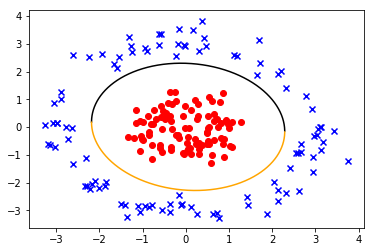

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def ring_sample_data(radius, variance, num_points):
    z = np.random.uniform(low=0, high=2*np.pi, size=num_points)
    r = np.random.normal(loc=radius, scale=variance, size=num_points)
    X = np.zeros((num_points, 2))
    X[:,0] = np.cos(z) * r
    X[:,1] = np.sin(z) * r
    return X

X_pos = ring_sample_data(3, 0.3, 100)
T_pos = np.tile([1,0], (100, 1))
X_neg = ring_sample_data(0.8, 0.3, 100)
T_neg = np.tile([0,1], (100, 1))
X = np.concatenate((X_pos, X_neg))
T = np.concatenate((T_pos, T_neg))

plt.scatter(X_pos[:,0], X_pos[:,1], marker="x", color="b")
plt.scatter(X_neg[:,0], X_neg[:,1], marker="o", color="r")

def phi_6(X):
    Phi = np.ones((X[:,0].size, 6))
    Phi[:,1] = X[:,0]
    Phi[:,2] = X[:,1]
    Phi[:,3] = np.square(X[:,0])
    Phi[:,4] = np.square(X[:,1])
    Phi[:,5] = X[:,0] * X[:,1]
    return Phi

Phi = phi_6(X)
W = np.linalg.pinv(Phi) @ T
w, v = W[:,0], W[:,1]
x = np.arange(-5, 5, 0.0001)
delta = (2 * (np.square(x) * (w[3] - v[3]) + x * (w[1] - v[1]) + (w[0] - v[0])) + (v[2] - w[2] + x * (v[5] - w[5]))) 
delta /= 2 * (v[4] - w[4])
y = np.zeros(x.size)

xs = []
y1s = []
y2s = []
for i in range(len(x)):
    if delta[i] < 0:
        continue
    y1 = np.sqrt(delta[i]) - (v[2]-w[2] + x[i]*(v[5] - w[5])) / (2 * (v[4] - w[4]))
    y2 = -np.sqrt(delta[i]) - (v[2]-w[2] + x[i]*(v[5] - w[5])) / (2 * (v[4] - w[4]))
    xs.append(x[i])
    y1s.append(y1)
    y2s.append(y2)

plt.plot(xs, y1s, color="black")
plt.plot(xs, y2s, color="orange")

## General linear discriminant functions

Idea: transform the vector $x$ with a nonlinear function $\phi$ before building its linear combination. In this case, lets try the following function:
$$
    \phi: \mathbb{R}^2 \rightarrow \mathbb{R}^6 \quad \quad
    \begin{pmatrix}
    x_1 \\ 
    x_2\end{pmatrix}
    \mapsto 
    \begin{pmatrix}
    1 \\
    x_1 \\
    x_2 \\
    x_1^2\\
    x_2^2\\
    x_1 \cdot x_2
    \end{pmatrix}
$$

As before, we multiply this transformed vector $\phi(x)$ with a weight vector $w_k \in \mathbb{R}^6$:
$$
    y_k(x; w_k) = w_k^T \cdot \phi(x)
$$

However, we now have the problem that we cannot simply use the least-squared method to find the optimal weight matrix. Instead, we have to use an iterative procedure to improve upon our weights over time. However, we still want to minimize the squared error:
$$
    E(w) = \sum_{n=1}^N E_n(w) =  \frac{1}{2} \sum_{n=1}^N \sum_{k=1}^K (y_k(x_n; w_k) - t_{n,k})^2 \\
        = \frac{1}{2} \sum_{n=1}^N \sum_{k=1}^K (w_k^T \cdot \phi(x) - t_{n,k})^2
$$

## Gradient descent

To minimize this function, we will start with some guess of the weight $w_{k,j}^{(0)}$ and improve upon it by following the gradient of $E$ with respect to $w_{k,j}$:

$$
w_{k,j}^{(t+1)} = w_{k,j}^{(t)} - \eta \cdot \frac{\partial E(w)}{\partial w_{k,j}}|_{w^{(t)}}
$$

We refer to the parameter $\eta$ as the learning rate of the gradient descent.

Let us now derive the update equations in detail, when $E_n(w)$ is defined as above:
$$
    \frac{\partial E_n(w)}{\partial w_{k,j}} = \frac{\partial}{\partial w_{k,j}} \frac{1}{2}  \sum_{\tilde{k}=1}^K  (w_\tilde{k}^T \cdot \phi(x_n) - t_{n,\tilde{k}})^2 \\
    = \frac{\partial}{\partial w_{k,j}} \frac{1}{2}  (w_k^T \cdot \phi(x_n) - t_{n,k})^2 \\
    = (w_k^T \cdot \phi(x_n) - t_{n,k}) \cdot \phi_j(x_n) \\
$$

Now, if we put all the entries $w_{k,j}$ together, we get the derivative of $E_n(w)$ with respect to the weight matrix $W = \begin{pmatrix}w_1 & w_2\end{pmatrix} \in \mathbb{R}^{6 \times 2}$
$$
    \frac{\partial E_n(w)}{\partial W} = \phi(x_n) \phi(x_n)^T W - \phi(x_n) t_n^T
$$
By summing over the $x_i$, we can derive the following equation:
$$
    \frac{\partial E(w)}{\partial W} = \sum_{n=1}^N \frac{\partial E_n(w)}{\partial W} \\
    = \sum_{n=1}^N \phi(x_n) \phi(x_n)^T W - \phi(x_n) t_n^T
$$

In [111]:
# maps a vector x \in \mathbb{R}^2 to x' \in \mathbb{R}^6
# the j-th entriy of the result vector can be seen as \phi_j(x)
def phi(x):
    return np.array([1, x[0], x[1], x[0]**2, x[1]**2, x[0]*x[1]])

def error(X, W):
    return np.sum(np.square(X @ W))

X = np.array(list(map(lambda x: phi(x), X[:,1:])))
W = np.random.normal(loc=0, scale=0.2, size=(6,2))
eta = 0.0001
N, D = X.shape

for _ in range(1000):
    dW = np.zeros((6,2))
    for n in range(N):
        phi_n = X[n,:]
        t_n = T[n,:]
        dW += np.square(phi_n) @ W - np.outer(phi_n, t_n)
    W -= eta * dW

error(X, W)

91802.05365023369